In [1]:
import numpy as np
# At the start of your notebook
from IPython.display import clear_output
import gc

# After heavy computations
clear_output(wait=True)
gc.collect()

0

In [2]:
from steps import setup_and_train_models, analyze_seizure_propagation

In [3]:
RESULT_FOLDER = "result"
MODEL_FOLDER = "model"
PAT_NO = 66
seizure_no = 1
model_name = 'Wavenet'

In [4]:
# Do batch analysis to find the best hyperparameters
seizures = [1, 2, 3]
thresholds = np.arange(0.5, 0.9, 0.05)
smooth_windows = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [5]:
results, models = setup_and_train_models(
    data_folder="data",
    model_folder="checkpoints",
    model_names=[model_name],  # Only use CNN1D and Wavenet
    train=False,
    params={'epochs': 40, 'batch_size': 4096}
)

In [6]:
results_propagation_total = []
model = models[model_name]
for threshold in thresholds:
    for smooth_window in smooth_windows:
        for seizure_no in seizures:
            params = {
                'threshold': threshold,
                'smooth_window': smooth_window,
                'n_seconds': 80,
                'seizure_start': 10,
            }
            results_propagation = analyze_seizure_propagation(
                patient_no=PAT_NO,
                seizure_no=seizure_no,
                model=model,
                data_folder='data',
                params=params,
                save_results_ind=False
            )
            results_propagation_total.append(results_propagation)

In [7]:
seizure_onset_probability = [results_propagation_total[i]['performance']['accuracy_onset_channels'] for i in range(len(results_propagation_total))]
seizure_all_channels = [results_propagation_total[i]['performance']['accuracy_all_channels'] for i in range(len(results_propagation_total))]

In [8]:
# Rearange the results so that it follows [threshold, smooth_window, seizure_no]
seizure_onset_probability = np.array(seizure_onset_probability).reshape(len(thresholds), len(smooth_windows), len(seizures))
seizure_all_channels = np.array(seizure_all_channels).reshape(len(thresholds), len(smooth_windows), len(seizures))

# Calculate the mean of the results for each threshold and smooth window
seizure_onset_probability_mean = np.mean(seizure_onset_probability, axis=2)
seizure_all_channels_mean = np.mean(seizure_all_channels, axis=2)

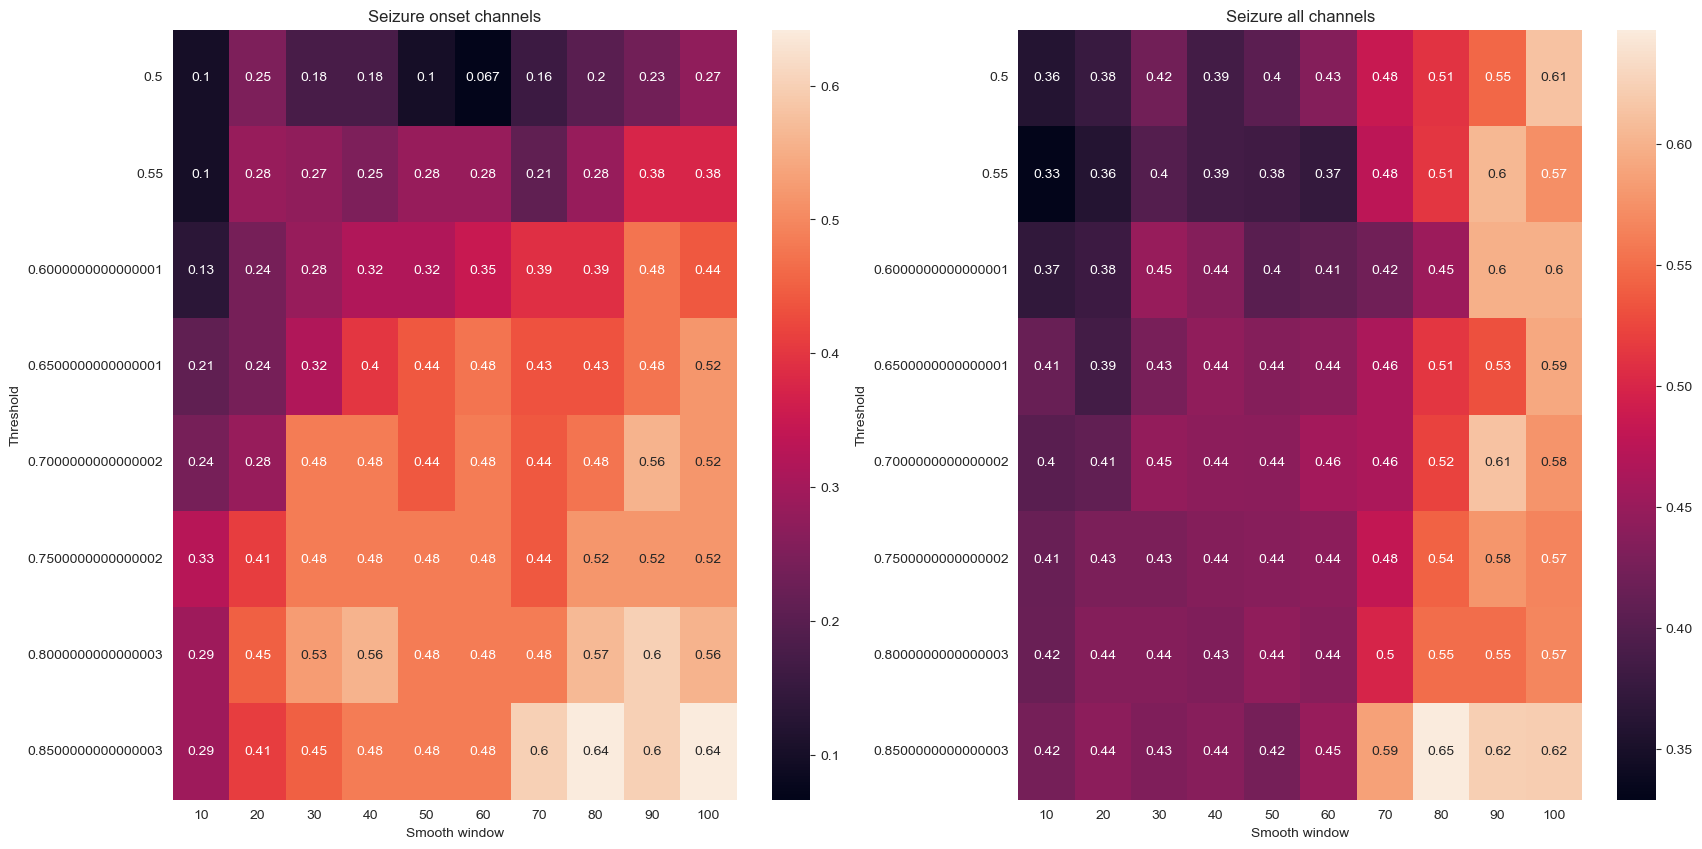

In [10]:
# Plot the results

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(seizure_onset_probability_mean, ax=ax[0], annot=True, xticklabels=smooth_windows, yticklabels=thresholds)
ax[0].set_title('Seizure onset channels')
ax[0].set_xlabel('Smooth window')
ax[0].set_ylabel('Threshold')

sns.heatmap(seizure_all_channels_mean, ax=ax[1], annot=True, xticklabels=smooth_windows, yticklabels=thresholds)
ax[1].set_title('Seizure all channels')
ax[1].set_xlabel('Smooth window')
ax[1].set_ylabel('Threshold')

plt.show()
